In [100]:
#Ignoring TF GPU warning messages
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [101]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import load_img
from skimage.io import imread, imshow
from skimage.transform import resize
import cv2
from tensorflow.keras.layers import (Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Flatten)
import innvestigate as inv

In [102]:
datadir = "dataset/nails/"
imagesDir = os.path.join(datadir, "images")
labelsDir = os.path.join(datadir, "labels")
img_size = (256,256)
num_classes = 2
batch_size = 16

In [103]:
def createDataset(images, labels):
    images = filter(lambda img: img.endswith(".jpg"), images)
    labels = filter(lambda img: img.endswith(".jpg"), labels)
#     print(list(labels))
    images = map(lambda img: os.path.join(imagesDir, img), images)
    labels = map(lambda imag: os.path.join(labelsDir, imag), labels)
#     print(list(labels))
    images = sorted(images)
    labels = sorted(labels)
    
    return images, labels

In [104]:
dataset = createDataset(os.listdir(imagesDir), os.listdir(labelsDir))

dataset/nails/images/09aefeec-e05f-11e8-87a6-0242ac1c0002.jpg
(340, 750, 3)


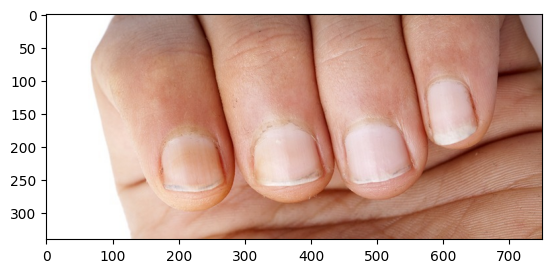

In [105]:
image = imread(dataset[0][0])
label = imread(dataset[1][0])
print(dataset[0][0])
plt.imshow(image)
print(image.shape)
# plt.imshow(label)

(340, 750, 3)
255


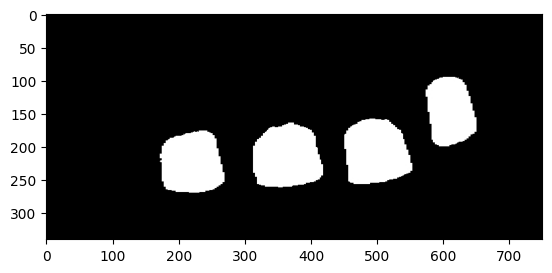

In [106]:
plt.imshow(label)
print(label.shape)
print(np.max(label))

In [107]:
dataset = pd.DataFrame(dataset).T

In [108]:
class NailDataset(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            image = imread(path)
#             print(image.shape)
#             imshow(image)
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, img_size)
            image = image/255.0
            x[j] = image
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            image = imread(path)
#             //print(image.shape)
#             imshow(image)
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, img_size)
    
#             print(image.shape)
#             imshow(image)
#             image = keras.utils.to_categorical(image, axis = -1)
            image = np.expand_dims(image, axis = -1)
            image = image/255.0
            y[j] = image
        return x, y

In [109]:
from tensorflow.keras.layers import (Input, Lambda, Conv2D, Dropout, MaxPooling2D, 
                                     Conv2DTranspose, concatenate)
from tensorflow.keras import Model
# Inputs
inputs = Input((256, 256, 3))
# Change integer to float and also scale pixel values

# Contraction/Encoder path
# Block 1
c1 = Conv2D(filters=16, kernel_size=(3,3),
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(inputs)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(filters=16, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(c1)
p1 = MaxPooling2D(pool_size=(2,2))(c1)
# Block 2
c2 = Conv2D(filters=32, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(filters=32, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(c2)
p2 = MaxPooling2D(pool_size=(2,2))(c2)
# Block 3
c3 = Conv2D(filters=64, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(filters=64, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(c3)
p3 = MaxPooling2D(pool_size=(2,2))(c3)
# Block 4
c4 = Conv2D(filters=128, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(filters=128, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2,2))(c4)
# Block 5
c5 = Conv2D(filters=256, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(filters=256, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(c5)

# Expansion/Decoder path
# Block 6
u6 = Conv2DTranspose(filters=128, kernel_size=(2,2), strides = (2,2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(filters=128, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(filters=128, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(c6)

# Block 7
u7 = Conv2DTranspose(filters=64, kernel_size=(2,2), strides = (2,2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(filters=64, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(filters=64, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(c7)

# Block 8
u8 = Conv2DTranspose(filters=32, kernel_size=(2,2), strides = (2,2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(filters=32, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(filters=32, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(c8)

# Block 9
u9 = Conv2DTranspose(filters=16, kernel_size=(2,2), strides = (2,2), padding='same')(c8)
u9 = concatenate([u9, c1])
c9 = Conv2D(filters=16, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(filters=16, kernel_size=(3,3), 
                            activation='relu', kernel_initializer='he_normal',
                           padding='same')(c9)
# Outputs
outputs = Conv2D(filters=1, kernel_size=(1,1), 
                            activation='sigmoid')(c9)

model = Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_306 (Conv2D)         (None, 256, 256, 16)         448       ['input_19[0][0]']            
                                                                                                  
 dropout_144 (Dropout)       (None, 256, 256, 16)         0         ['conv2d_306[0][0]']          
                                                                                                  
 conv2d_307 (Conv2D)         (None, 256, 256, 16)         2320      ['dropout_144[0][0]']         
                                                                                           

In [110]:
from tensorflow.keras.layers import (Input, Lambda, Conv2D, Dropout, MaxPooling2D, 
                                     Conv2DTranspose, concatenate)
from tensorflow.keras import Model
def get_model(weights = None, flatten = False, last_activation="sigmoid"):
    inputs = Input((256, 256, 3))
    # Change integer to float and also scale pixel values

    # Contraction/Encoder path
    # Block 1
    c1 = Conv2D(filters=16, kernel_size=(3,3),
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(filters=16, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2,2))(c1)
    # Block 2
    c2 = Conv2D(filters=32, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(filters=32, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2,2))(c2)
    # Block 3
    c3 = Conv2D(filters=64, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(filters=64, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(c3)
    p3 = MaxPooling2D(pool_size=(2,2))(c3)
    # Block 4
    c4 = Conv2D(filters=128, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(filters=128, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2,2))(c4)
    # Block 5
    c5 = Conv2D(filters=256, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(filters=256, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(c5)

    # Expansion/Decoder path
    # Block 6
    u6 = Conv2DTranspose(filters=128, kernel_size=(2,2), strides = (2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(filters=128, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(filters=128, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(c6)

    # Block 7
    u7 = Conv2DTranspose(filters=64, kernel_size=(2,2), strides = (2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(filters=64, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(filters=64, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(c7)

    # Block 8
    u8 = Conv2DTranspose(filters=32, kernel_size=(2,2), strides = (2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(filters=32, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(filters=32, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(c8)

    # Block 9
    u9 = Conv2DTranspose(filters=16, kernel_size=(2,2), strides = (2,2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(filters=16, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(filters=16, kernel_size=(3,3), 
                                activation='relu', kernel_initializer='he_normal',
                               padding='same')(c9)
    # Outputs
    outputs = Conv2D(filters=1, kernel_size=(1,1), 
                                activation=last_activation)(c9)
    
    if(flatten):
        outputs = Flatten()(outputs)
        
    model = Model(inputs=[inputs], outputs=[outputs])
    
    if weights is not None:
        model.load_weights(weights)
    return model

model = get_model()

model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_325 (Conv2D)         (None, 256, 256, 16)         448       ['input_20[0][0]']            
                                                                                                  
 dropout_153 (Dropout)       (None, 256, 256, 16)         0         ['conv2d_325[0][0]']          
                                                                                                  
 conv2d_326 (Conv2D)         (None, 256, 256, 16)         2320      ['dropout_153[0][0]']         
                                                                                           

In [111]:
import random
val_samples = 6 # 85% Training -- 15% Validation
random.Random(1822).shuffle(imageList)
random.Random(1822).shuffle(labelList)
print(imageList[0])
print(labelList[0])
train_input_img_paths = imageList[:-val_samples]
train_target_img_paths = labelList[:-val_samples]
print(train_input_img_paths[0], train_target_img_paths[0])
val_input_img_paths = imageList[-val_samples:]
val_target_img_paths = labelList[-val_samples:]

# Instantiate data Sequences for each split
train_gen = NailDataset(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = NailDataset(6, img_size, val_input_img_paths, val_target_img_paths)

dataset/nails/images/4c47ee66-e402-11e8-97db-0242ac1c0002.jpg
dataset/nails/labels/4c47ee66-e402-11e8-97db-0242ac1c0002.jpg
dataset/nails/images/4c47ee66-e402-11e8-97db-0242ac1c0002.jpg dataset/nails/labels/4c47ee66-e402-11e8-97db-0242ac1c0002.jpg


In [112]:
from tensorflow.keras.losses import Loss
import tensorflow.keras.backend as K

# Loss function
def bce_loss(y_true,y_pred):
    y_true=K.cast(y_true,'float32')
    y_pred=K.cast(y_pred,'float32')
    return tf.keras.losses.binary_crossentropy(y_true,y_pred)
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')
    
    intersection = K.sum(y_true_f * y_pred_f)
    dice_coef_v = (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)
    return dice_coef_v
def dice_loss(y_true, y_pred):
    dice_loss_v = 1 - dice_coef(y_true, y_pred)
    return dice_loss_v
def bce_dice_loss(y_true, y_pred):
    bce_dice_loss_v = bce_loss(y_true, y_pred) + dice_loss(y_true, y_pred)
    return bce_dice_loss_v

In [115]:
optimizer = keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer="adam", loss=bce_dice_loss, metrics=[dice_coef])

callbacks = [
    keras.callbacks.ModelCheckpoint("cancerSegmentation.h5", save_best_only=True)
]

epochs = 100
#modelunet=model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

In [116]:
modelunet=model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

ValueError: could not broadcast input array from shape (256,256,3,1) into shape (256,256,1)